## Семинар: "Методы оптимизации"

In [1]:
from functools import partial
import math
import numpy as np
import torch.nn.functional as F
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

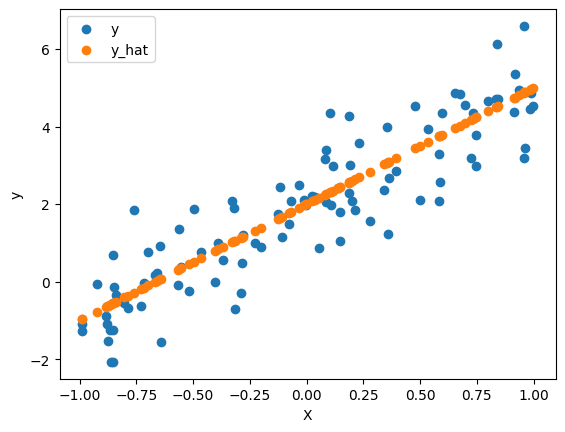

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

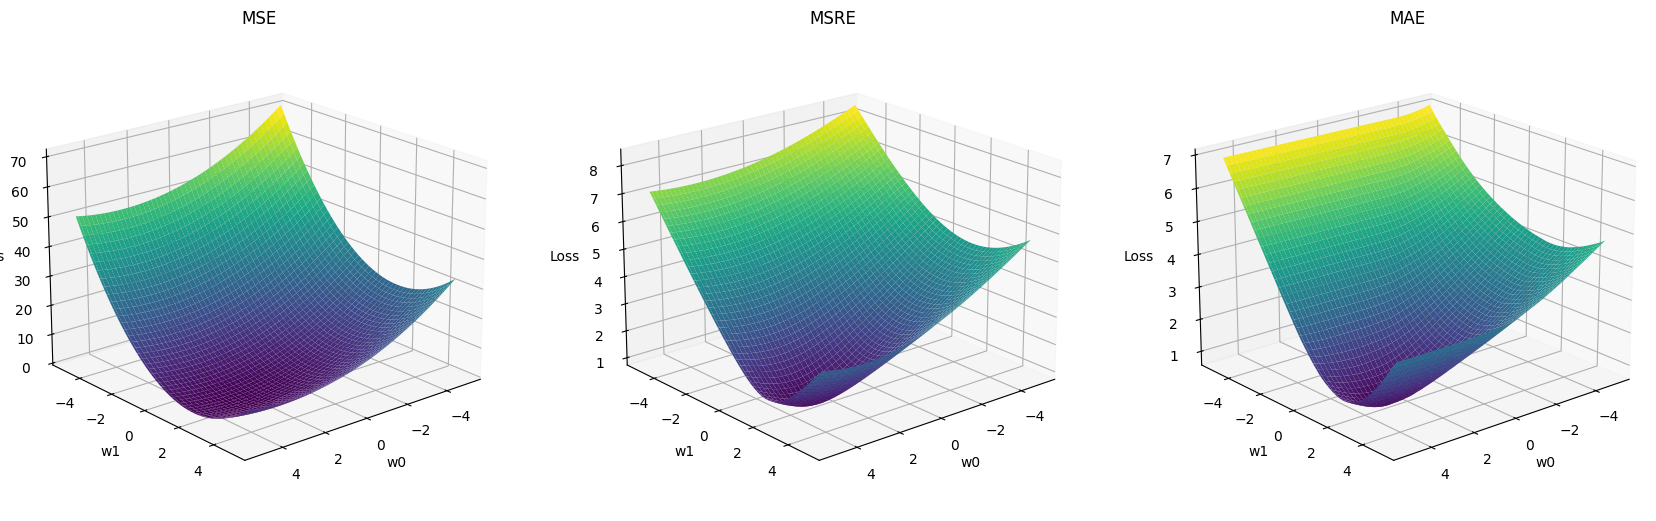

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)
    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [11]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [12]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [13]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [14]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-10-05 15:33:29--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-10-05 15:33:29--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  20.5MB/s    in 1.6s    

2025-10-05 15:33:31 (20.5 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [16]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Напишем класс сверточной нейронной сети

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Опишем классы шедулеров для поиска лернинг рейта

In [41]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass


In [54]:
import math

class LinearLR:
    def __init__(self, optimizer, start_factor=0.0001, end_factor=0.5, total_iters=100):
        self.optimizer = optimizer
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.iter = 0
        try:
          self.base_lr = optimizer.lr
        except:
          self.base_lr = optimizer.param_groups[0]['lr']

    def step(self):
        self.iter += 1
        factor = self.start_factor + (self.end_factor - self.start_factor) * min(self.iter / self.total_iters, 1.0)
        try:
          self.optimizer.lr = self.base_lr * factor
        except:
          self.optimizer.lr = optimizer.param_groups[0]['lr']


class CosineAnnealingLR:
    def __init__(self, optimizer, T_max, eta_min=0):
        self.optimizer = optimizer
        self.T_max = T_max
        self.eta_min = eta_min
        self.iter = 0
        try:
          self.base_lr = optimizer.lr
        except:
          self.base_lr =  optimizer.param_groups[0]['lr']

    def step(self):
        self.iter += 1
        new_lr = self.eta_min + (self.base_lr - self.eta_min) * (1 + math.cos(math.pi * self.iter / self.T_max)) / 2
        try:
          self.optimizer.lr = new_lr
        except:
          self.optimizer.lr = optimizer.param_groups[0]['lr']




In [81]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    @torch.no_grad()
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue

            grad = p.grad

            if self.weight_decay != 0:
                p.mul_(1 - self.lr * self.weight_decay)

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad * grad)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)


class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    @torch.no_grad()
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue

            grad = p.grad

            if self.weight_decay != 0:
                p.mul_(1 - self.lr * self.weight_decay)

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad * grad)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)



Эксперимент: SGD_none
Epoch 1: loss=0.3838, acc=0.9609
Epoch 2: loss=0.1050, acc=0.9763
Epoch 3: loss=0.0732, acc=0.9795
Epoch 4: loss=0.0589, acc=0.9836
Epoch 5: loss=0.0502, acc=0.9857
Epoch 6: loss=0.0431, acc=0.9861

Эксперимент: SGD_LinearLR
Epoch 1: loss=0.4076, acc=0.9634
Epoch 2: loss=0.1111, acc=0.9756
Epoch 3: loss=0.0754, acc=0.9813
Epoch 4: loss=0.0602, acc=0.9861
Epoch 5: loss=0.0496, acc=0.9873
Epoch 6: loss=0.0421, acc=0.9823

Эксперимент: SGD_CosineAnnealingLR
Epoch 1: loss=0.4431, acc=0.9507
Epoch 2: loss=0.1127, acc=0.9718
Epoch 3: loss=0.0776, acc=0.9773
Epoch 4: loss=0.0604, acc=0.9846
Epoch 5: loss=0.0497, acc=0.9848
Epoch 6: loss=0.0425, acc=0.9851

Эксперимент: Adam_none
Epoch 1: loss=0.1867, acc=0.9725
Epoch 2: loss=0.1088, acc=0.9750
Epoch 3: loss=0.1042, acc=0.9757
Epoch 4: loss=0.0977, acc=0.9713
Epoch 5: loss=0.0963, acc=0.9718
Epoch 6: loss=0.0910, acc=0.9698

Эксперимент: Adam_LinearLR
Epoch 1: loss=0.1648, acc=0.9810
Epoch 2: loss=0.0573, acc=0.9809
Epoc

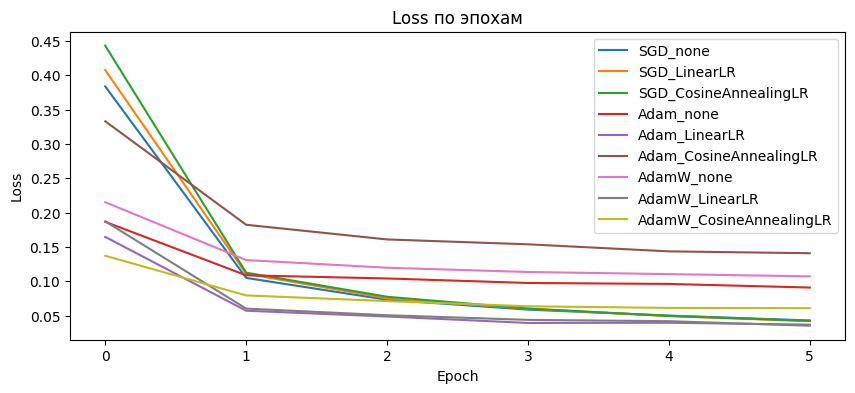

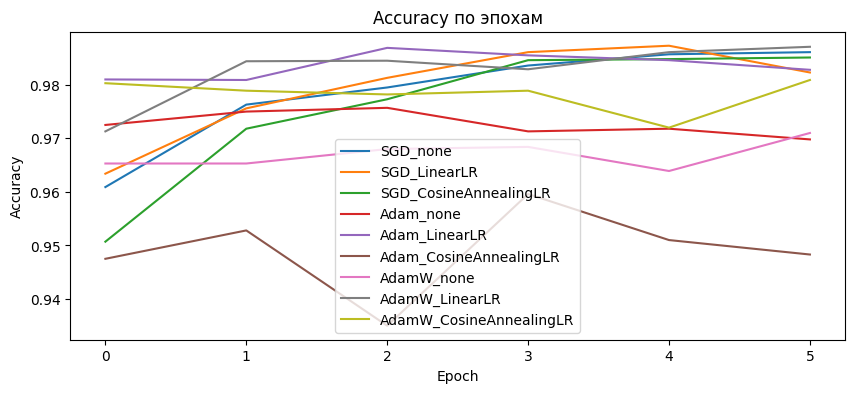

In [87]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def train_one_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    total_loss, correct = 0, 0
    batch_losses, batch_accs = [], []
    total_samples = 0

    for batch_idx, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        pred = model(x)
        loss = F.cross_entropy(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        #print(f"LR={optimizer.lr if hasattr(optimizer, 'lr') else 'n/a'}")

        total_loss += loss.item() * x.size(0)
        correct += (pred.argmax(1) == y).sum().item()
        total_samples += x.size(0)
        if batch_idx % 600 == 0:
          batch_losses.append(loss.item())
          batch_accs.append((pred.argmax(1) == y).float().mean().item())

    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    return avg_loss, avg_acc, batch_losses, batch_accs

def test_model(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            total_loss += F.cross_entropy(pred, y).item() * x.size(0)
            correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

optimizers = {
    "SGD": lambda params: torch.optim.SGD(params, lr=0.01),
    "Adam": lambda params: Adam(params, lr=0.01),
    "AdamW": lambda params: AdamW(params, lr=0.01, weight_decay=0.01)
}

schedulers = {
    "none": lambda opt: None,
    "LinearLR": lambda opt: LinearLR(opt, total_iters=100),
    "CosineAnnealingLR": lambda opt: CosineAnnealingLR(opt, T_max=100)
}

results = {}
EPOCHS = 6
all_batch_losses = {}

for opt_name, opt_fn in optimizers.items():
    for sch_name, sch_fn in schedulers.items():
        key = f"{opt_name}_{sch_name}"
        print(f"\nЭксперимент: {key}")
        model = SimpleCNN()
        optimizer = opt_fn(model.parameters())
        scheduler = sch_fn(optimizer)

        train_losses, test_acc = [], []
        batch_losses_total = []

        for epoch in range(EPOCHS):
            tr_loss, tr_acc, batch_losses, _ = train_one_epoch(model, train_loader, optimizer, scheduler)
            te_loss, te_acc = test_model(model, test_loader)
            train_losses.append(tr_loss)
            test_acc.append(te_acc)
            batch_losses_total.extend(batch_losses)
            print(f"Epoch {epoch+1}: loss={tr_loss:.4f}, acc={te_acc:.4f}")

        results[key] = {"loss": train_losses, "acc": test_acc}
        all_batch_losses[key] = batch_losses_total

plt.figure(figsize=(10,4))
for k,v in results.items():
    plt.plot(v["loss"], label=k)
plt.title("Loss по эпохам")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
for k,v in results.items():
    plt.plot(v["acc"], label=k)
plt.title("Accuracy по эпохам")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# === Loss по батчам (для каждого эксперимента) ===
#plt.figure(figsize=(10,4))
#for k,v in all_batch_losses.items():
#    plt.plot(v, label=k, alpha=0.7)
#plt.title("Loss по батчам (сквозь все эпохи)")
#plt.xlabel("Batch")
#plt.ylabel("Loss")
#plt.legend()
#plt.show()

Лучший результат:

* AdamW + LinearLR — максимальная точность (0.9871) и минимальный loss (0.0354).

* SGD работает стабильно, но не лучше AdamW при LinearLR.

* Adam без scheduler’а быстро деградирует, требует регулирования LR.

* CosineAnnealingLR показал себя хуже LinearLR во всех случаях.

* LinearLR стабильно улучшает сходимость Adam и AdamW, делает обучение более гладким и эффективным.